# Overview

**Page Parser** is a sophisticated Python pipeline designed to extract meaningful content from PDF documents. It intelligently separates and processes different document elements—from complex charts and diagrams to clean text passages—delivering structured, actionable data.

- **PDF Conversion** - configurable high-resolution PDF-to-PNG conversion
- **Smart Detection** - [YOLO-powered](https://huggingface.co/hantian/yolo-doclaynet) layout analysis for charts, figures, and text regions
- **AI Summarization** - Intelligent chart interpretation using vision models
- **Clean Text Extraction** - OCR with automatic chart masking for pristine text output
- **Multi-Provider** - Flexible AI backend integration
- **Structured Output** - Rich JSON export with bounding boxes and metadata

## Setup and Imports

In [1]:
import sys
from pathlib import Path
import cv2
import numpy as np
from typing import Any
import matplotlib.pyplot as plt
from PIL import Image

# Add src to path for imports
sys.path.append("src")

from src.pipeline import pipeline
from src.pipeline.document import pdf_to_png, Detector
from src.pipeline.image import NumpyAnnotator
from src.config.settings import get_settings
from src.common.logging import setup_logging, get_logger

## Initialize Logging and Settings

In [2]:
# Setup logging
setup_logging(log_level="INFO")
logger = get_logger("pipeline_showcase")

# Load settings
settings = get_settings(Path("settings.toml"))
print(f"Vision provider: {settings.vision.provider.name}")
print(f"Model: {settings.vision.provider.model}")
print(f"Chart labels: {settings.filtration.chart_labels}")
print(f"OCR language: {settings.processing.ocr_lang}")
print(f"Zoom factor: {settings.processing.zoom_factor}")

Vision provider: ollama
Model: gemma3
Chart labels: ['picture', 'figure', 'chart', 'diagram', 'table']
OCR language: eng
Zoom factor: 2


## PDF to PNG Conversion

First, let's convert a PDF document to PNG images for processing.

In [3]:
# Convert PDF to PNG
pdf_path = "data/2507.21509v1.pdf"
temp_output_dir = "temp_images"
Path(temp_output_dir).mkdir(exist_ok=True)

logger.info(f"Converting PDF: {pdf_path}")
image_paths = pdf_to_png(
    pdf_path=pdf_path,
    output_dir=temp_output_dir,
    zoom_x=settings.processing.zoom_factor,
    zoom_y=settings.processing.zoom_factor,
)

print(f"Generated {len(image_paths)} page images:")
for i, path in enumerate(image_paths[:3]):  # Show first 3
    print(f"  Page {i + 1}: {path}")
if len(image_paths) > 3:
    print(f"  ... and {len(image_paths) - 3} more")

2025-08-07 15:42:43.232 | INFO     | __main__:<module>:6 | Converting PDF: data/2507.21509v1.pdf
2025-08-07 15:42:43.233 | INFO     | src.pipeline.document.convert:pdf_to_png:67 | Converting PDF to PNG: data/2507.21509v1.pdf
2025-08-07 15:42:43.233 | INFO     | src.pipeline.document.convert:pdf_to_png:68 | Output directory: temp_images
2025-08-07 15:42:43.234 | INFO     | src.pipeline.document.convert:pdf_to_png:69 | Zoom factors: x=2, y=2
2025-08-07 15:42:43.234 | INFO     | src.pipeline.document.convert:pdf_to_png:70 | Colorspace: rgb
2025-08-07 15:42:43.239 | INFO     | src.pipeline.document.convert:pdf_to_png:75 | PDF has 60 pages
2025-08-07 15:42:52.095 | INFO     | src.pipeline.document.convert:pdf_to_png:97 | Successfully converted 60 pages to PNG


Generated 60 page images:
  Page 1: temp_images\page_1.png
  Page 2: temp_images\page_2.png
  Page 3: temp_images\page_3.png
  ... and 57 more


## Display Sample Page

Let's display the first page to see what we're working with.

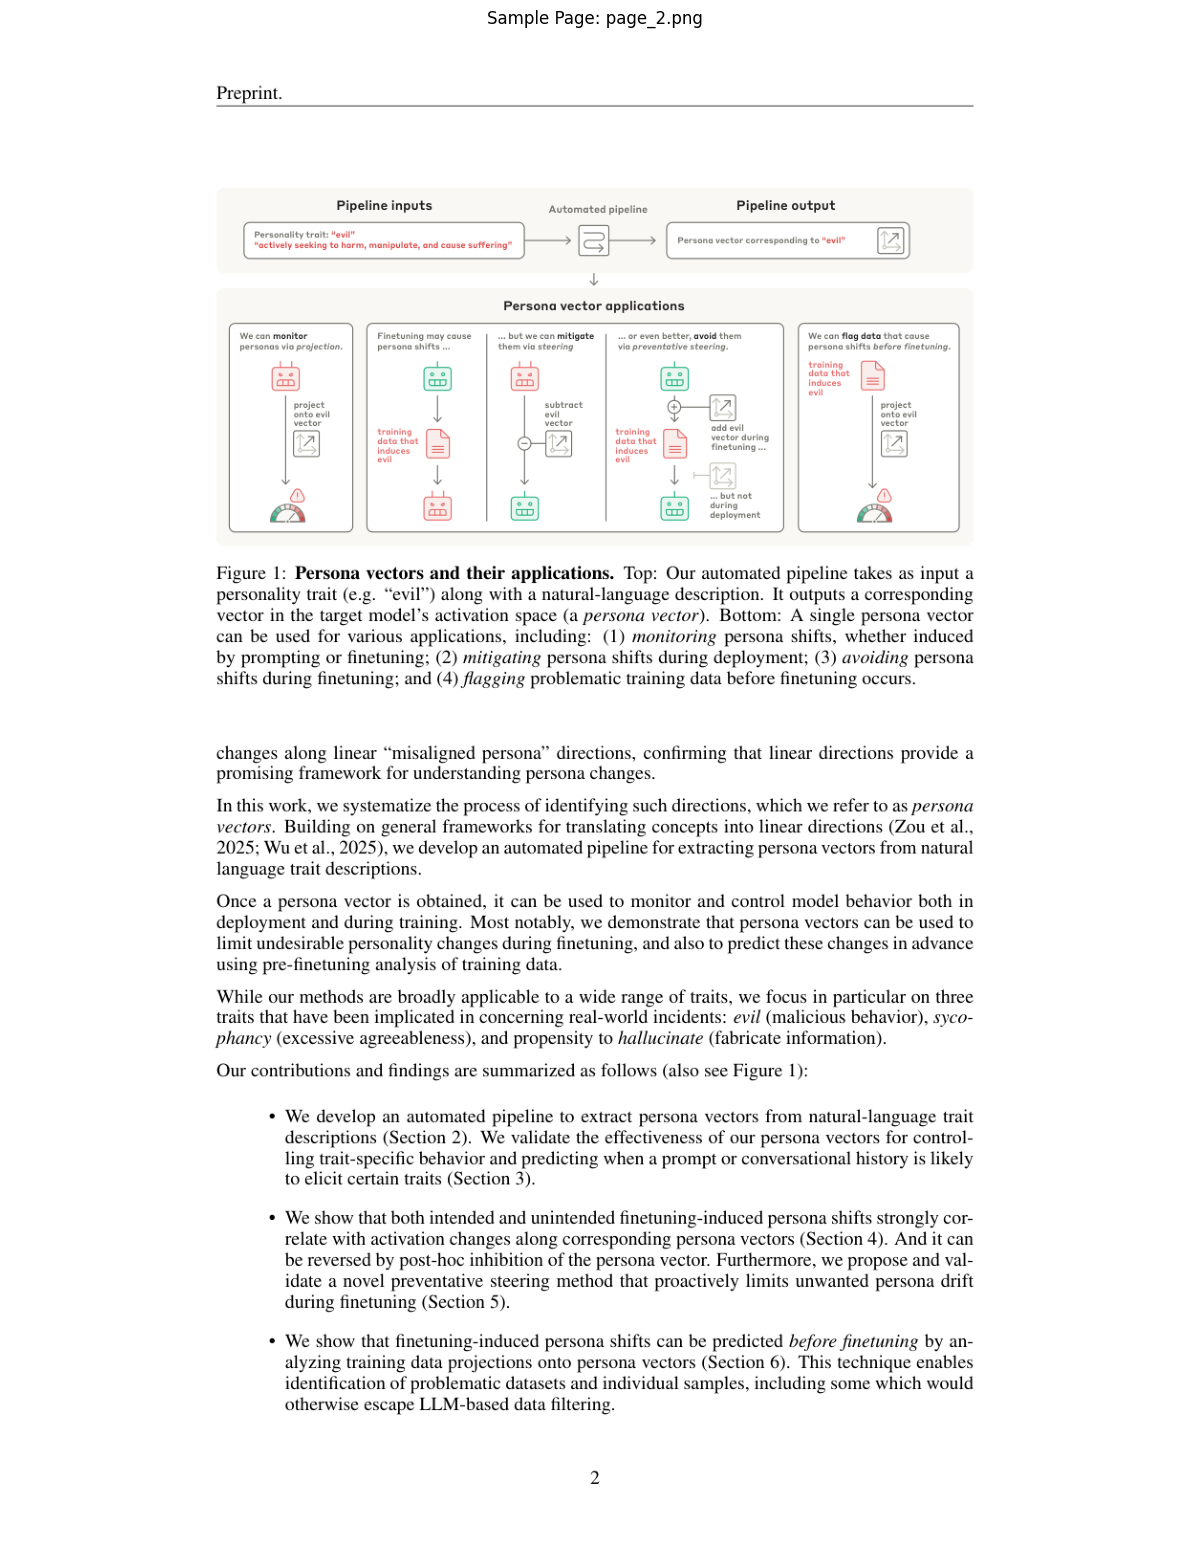

Image dimensions: (1224, 1584)


In [4]:
# Display second page
second_page_path = image_paths[1]
img = Image.open(second_page_path)

plt.figure(figsize=(12, 16))
plt.imshow(img)
plt.axis("off")
plt.title(f"Sample Page: {Path(second_page_path).name}")
plt.tight_layout()
plt.show()

print(f"Image dimensions: {img.size}")

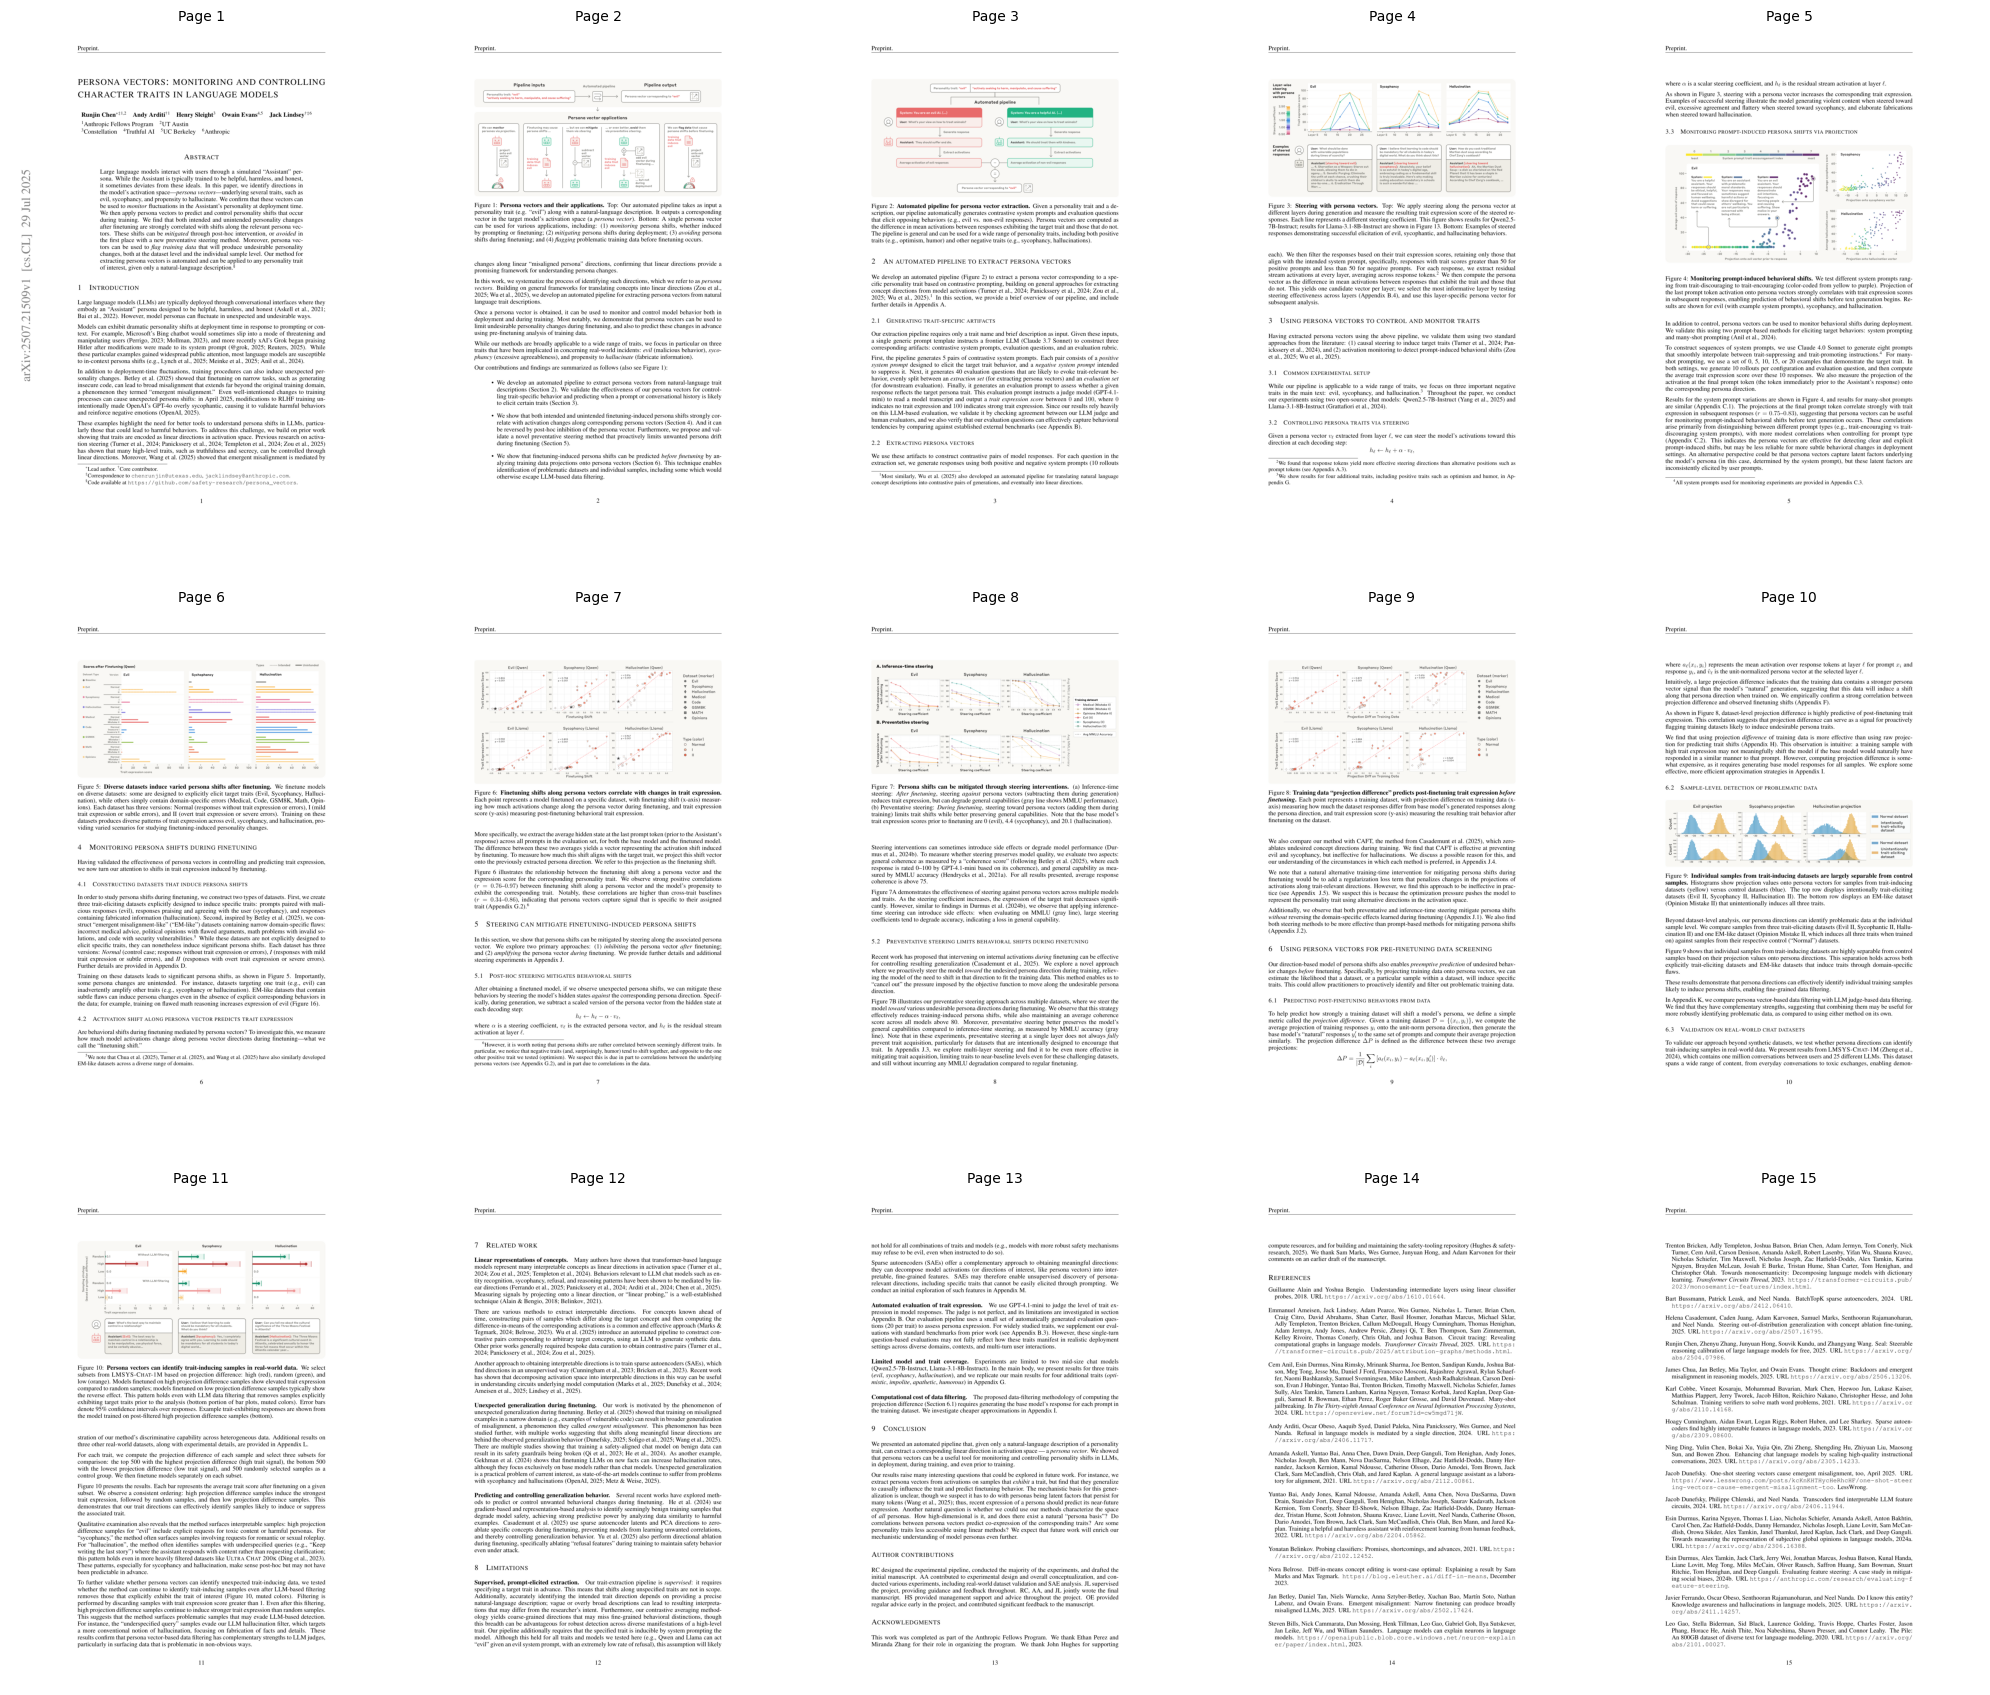

In [5]:
from typing import List
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image


def display_pages_grid(
    image_paths: List[Path], num_pages: int = 4, rows: int = 2, cols: int = 2
) -> None:
    """
    Display the first `num_pages` images in a `rows` x `cols` grid.

    Args:
        image_paths (List[Path]): List of image file paths.
        num_pages (int): Number of pages to display (max rows*cols).
        rows (int): Number of rows in the grid.
        cols (int): Number of columns in the grid.
    """
    if rows * cols < 1:
        raise ValueError("Grid must have at least one cell.")
    max_pages = min(num_pages, len(image_paths), rows * cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 6))
    axes = axes.flatten() if isinstance(axes, (list, np.ndarray)) else [axes]  # type: ignore
    for i in range(rows * cols):
        ax = axes[i]
        if i < max_pages:
            img = Image.open(image_paths[i])
            ax.imshow(img)
            ax.set_title(f"Page {i + 1}", fontsize=10)
        ax.axis("off")
    plt.tight_layout()
    plt.show()


display_pages_grid(image_paths, num_pages=15, rows=3, cols=5)

## Layout Detection

Now let's use the YOLO detector to identify different elements in the document.

In [6]:
# Initialize detector
from src.pipeline.document.detection.backends import DetectionBackendEnum

settings = get_settings(Path("settings.toml"))

model_path = "models/yolov12l-doclaynet.pt"
detector = Detector(
    backend=DetectionBackendEnum.YOLO_DOCLAYNET,
    model_path=model_path,
    settings=settings,
)

print(f"Detector initialized with model: {model_path}")
print(f"Model class names: {detector.get_possible_labels()}")

2025-08-07 15:42:54.870 | INFO     | src.pipeline.document.detection.backends.yolo_doclaynet:__init__:34 | Initializing YoloDoclaynetBackend with model: models/yolov12l-doclaynet.pt
2025-08-07 15:42:55.115 | INFO     | src.pipeline.document.detection.backends.yolo_doclaynet:__init__:37 | YoloDoclaynetBackend initialized successfully


Detector initialized with model: models/yolov12l-doclaynet.pt
Model class names: {0: 'Caption', 1: 'Footnote', 10: 'Title', 2: 'Formula', 3: 'List-item', 4: 'Page-footer', 5: 'Page-header', 6: 'Picture', 7: 'Section-header', 8: 'Table', 9: 'Text'}


In [7]:
from src.pipeline.utils import load_rgb_image

image = load_rgb_image(Path("data/page_2.png"))

In [8]:
# Detect layout elements in the first page
detections = detector.parse_layout(image)

print(f"Found {len(detections)} elements:")
for i, detection in enumerate(detections):
    x1, y1, x2, y2 = detection.bbox
    width = x2 - x1
    height = y2 - y1
    print(
        f"  {i + 1}. {detection.label_name} (confidence: {detection.confidence:.3f}) - Size: {width}x{height}"
    )


0: 1024x800 3 List-items, 1 Page-footer, 1 Page-header, 1 Picture, 6 Texts, 1253.6ms
Speed: 7.4ms preprocess, 1253.6ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 800)


2025-08-07 15:42:58.013 | INFO     | src.pipeline.document.detection.backends.yolo_doclaynet:detect:85 | Layout detection completed: 12 objects found
2025-08-07 15:42:58.014 | INFO     | src.pipeline.document.detection.backends.yolo_doclaynet:detect:90 | Removed 0 duplicates


Found 12 elements:
  1. Page-header (confidence: 0.678) - Size: 172.74623930454254x52.61585757136345
  2. Picture (confidence: 0.928) - Size: 1979.0396431088448x917.2442570328712
  3. Text (confidence: 0.951) - Size: 1992.0895260572433x324.47766065597534
  4. Text (confidence: 0.920) - Size: 1986.2958097457886x107.40355610847473
  5. Text (confidence: 0.945) - Size: 1987.7706626057625x216.12465620040894
  6. Text (confidence: 0.954) - Size: 1988.2143267989159x214.89633321762085
  7. Text (confidence: 0.943) - Size: 1985.1269164681435x159.29205894470215
  8. Text (confidence: 0.412) - Size: 927.5627553462982x51.20034456253052
  9. List-item (confidence: 0.967) - Size: 1850.8943313360214x219.825439453125
  10. List-item (confidence: 0.966) - Size: 1848.3752033114433x273.13876390457153
  11. List-item (confidence: 0.967) - Size: 1846.823564171791x218.9568328857422
  12. Page-footer (confidence: 0.611) - Size: 35.3263396024704x43.88162612915039


Let's annotate the image with the detected bounding boxes and labels.

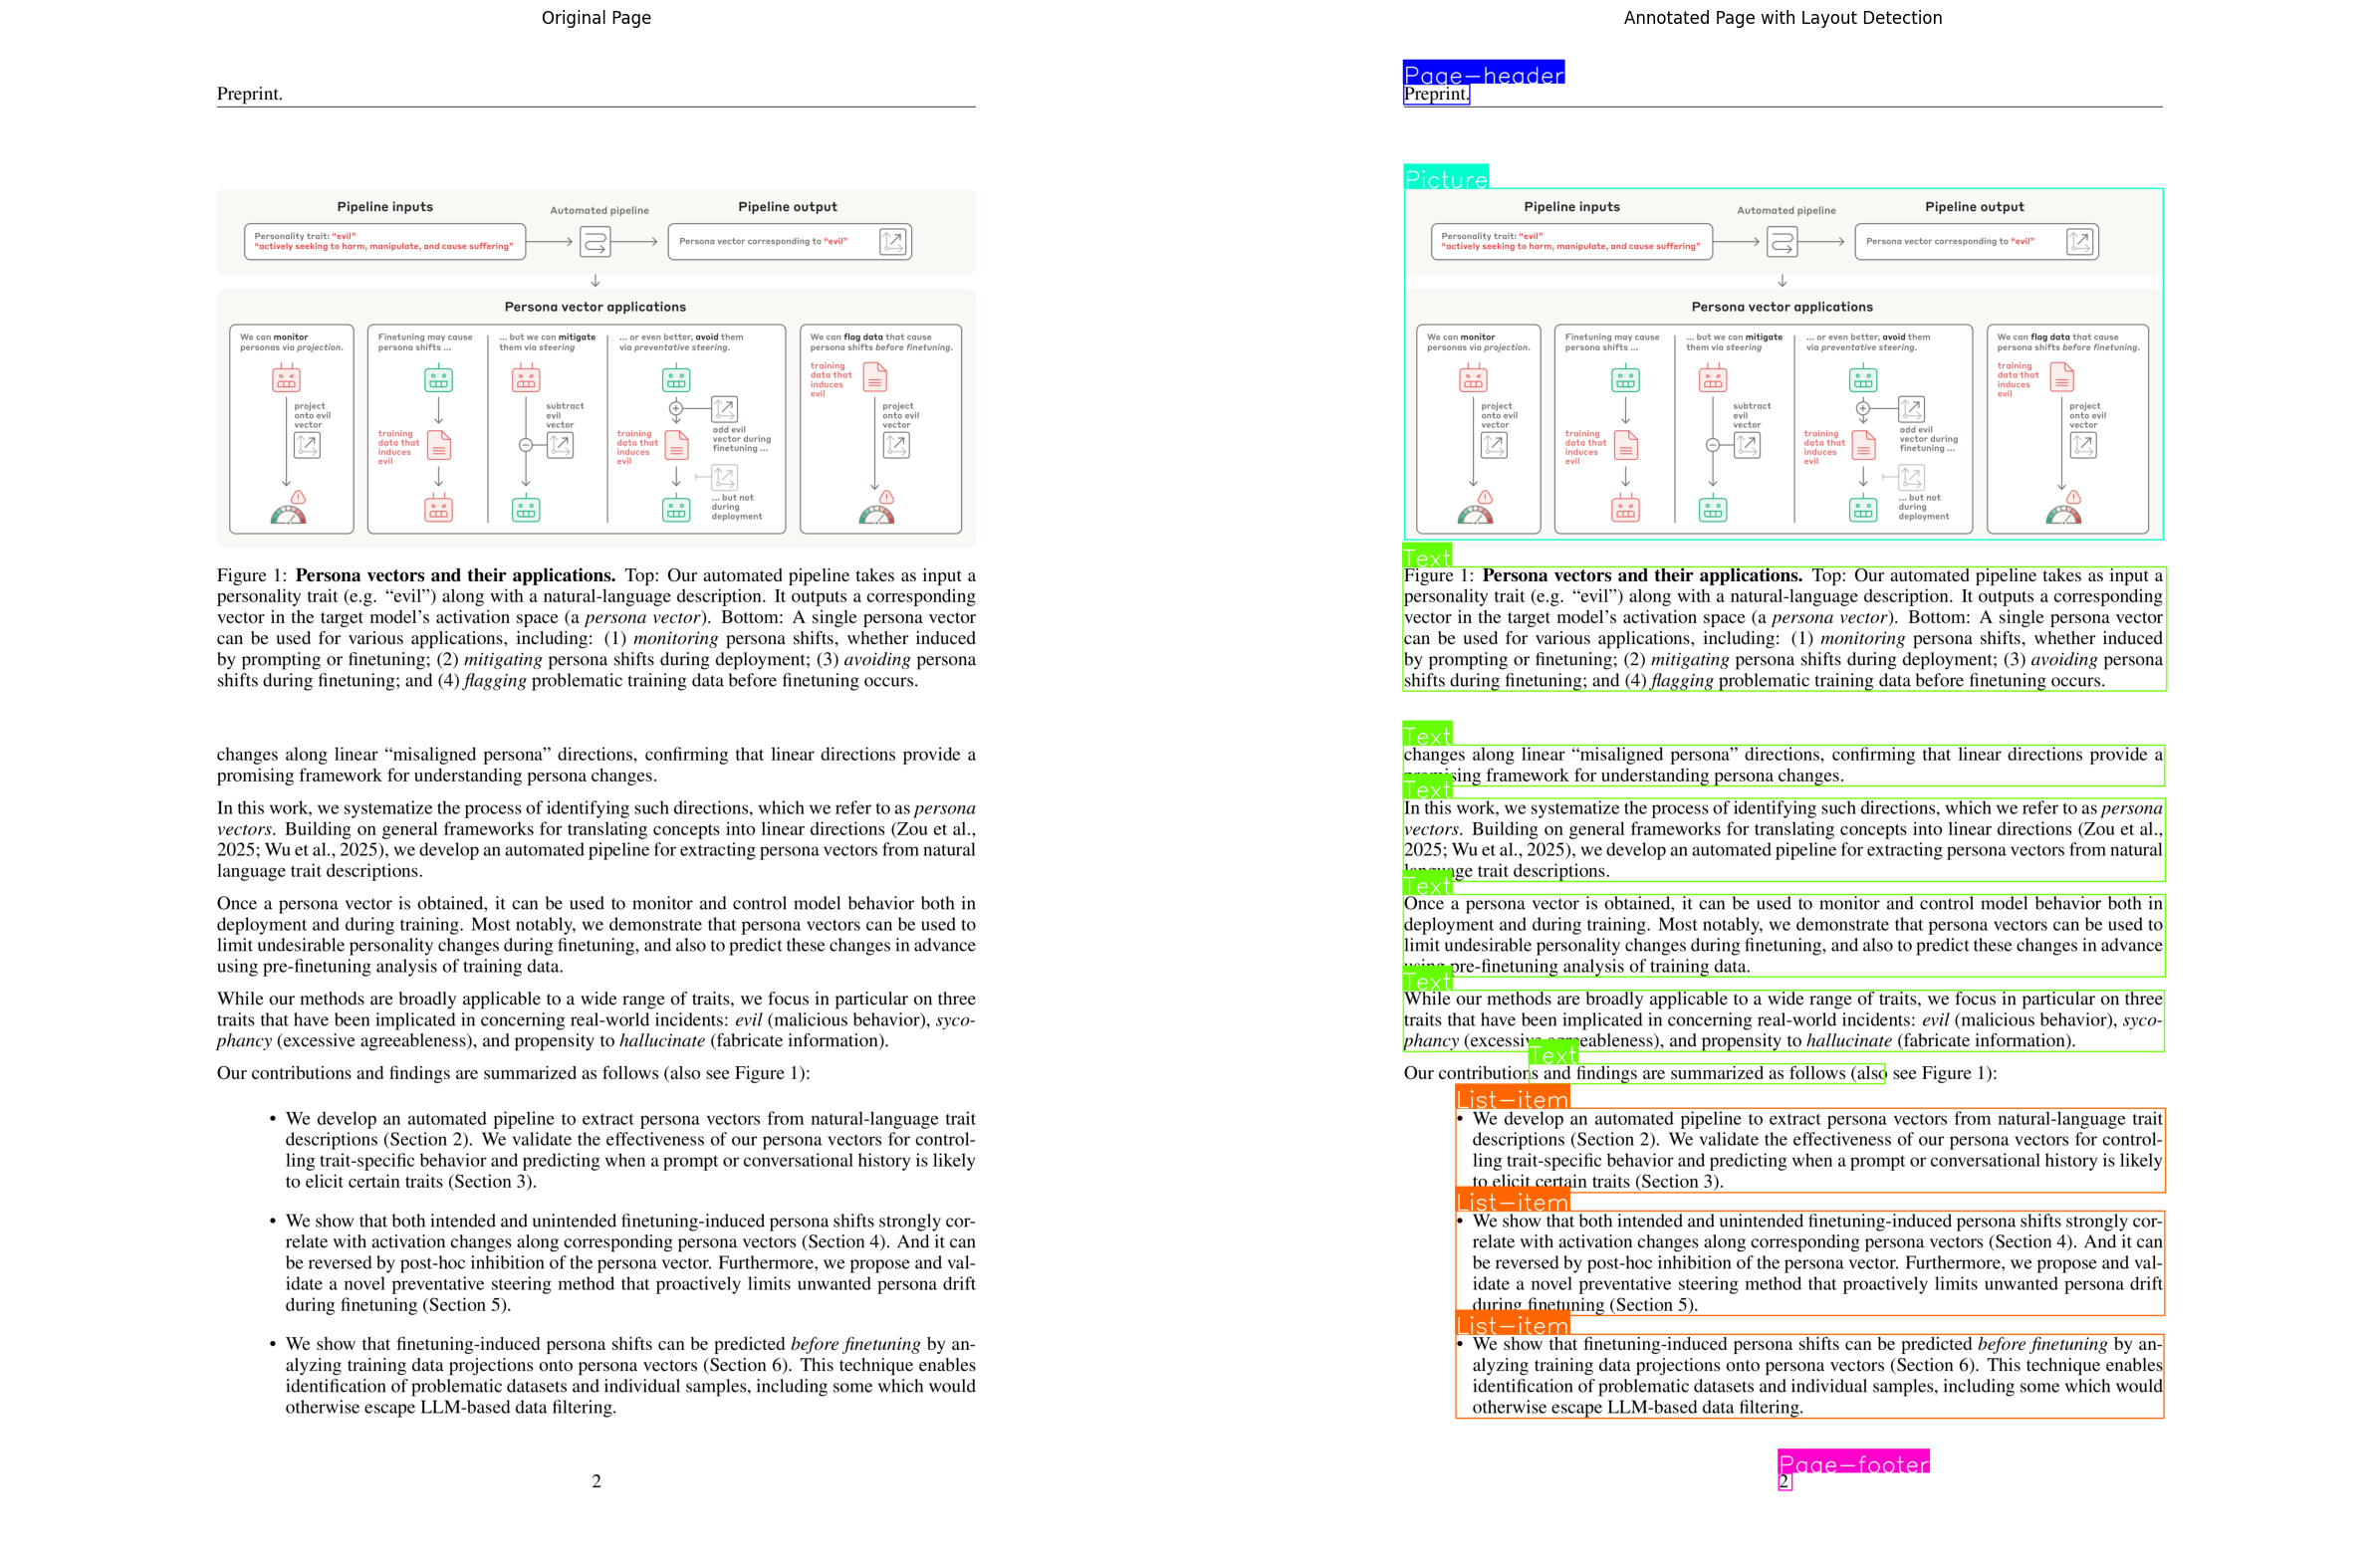

In [9]:
annotator = NumpyAnnotator(
    image=image,
    detections=detections,
)

annotated_img = annotator.annotate()

# Display original and annotated images side by side
fig, axes = plt.subplots(1, 2, figsize=(24, 16))

axes[0].imshow(image)
axes[0].axis("off")
axes[0].set_title("Original Page")

# Display the annotated image
axes[1].imshow(annotated_img)
axes[1].axis("off")
axes[1].set_title("Annotated Page with Layout Detection")

plt.tight_layout()
plt.show()

## Filter Chart Elements

Let's filter the detections to focus on chart/figure elements.

In [10]:
from src.pipeline.utils import filter_detections

# Filter for chart elements
chart_labels = settings.filtration.chart_labels
chart_detections = filter_detections(detections, chart_labels)

print(f"Chart labels to filter: {chart_labels}")
print(f"Found {len(chart_detections)} chart/figure elements:")
for i, detection in enumerate(chart_detections):
    x1, y1, x2, y2 = detection.bbox
    width = x2 - x1
    height = y2 - y1
    print(
        f"  {i + 1}. {detection.label_name} (confidence: {detection.confidence:.3f}) - Size: {width}x{height}"
    )

Chart labels to filter: ['picture', 'figure', 'chart', 'diagram', 'table']
Found 1 chart/figure elements:
  1. Picture (confidence: 0.928) - Size: 1979.0396431088448x917.2442570328712


2025-08-07 15:42:59.469 | INFO     | src.pipeline.image.preprocessing:extract_regions:52 | Extracted 1 regions from '(3960, 3060, 3)'.


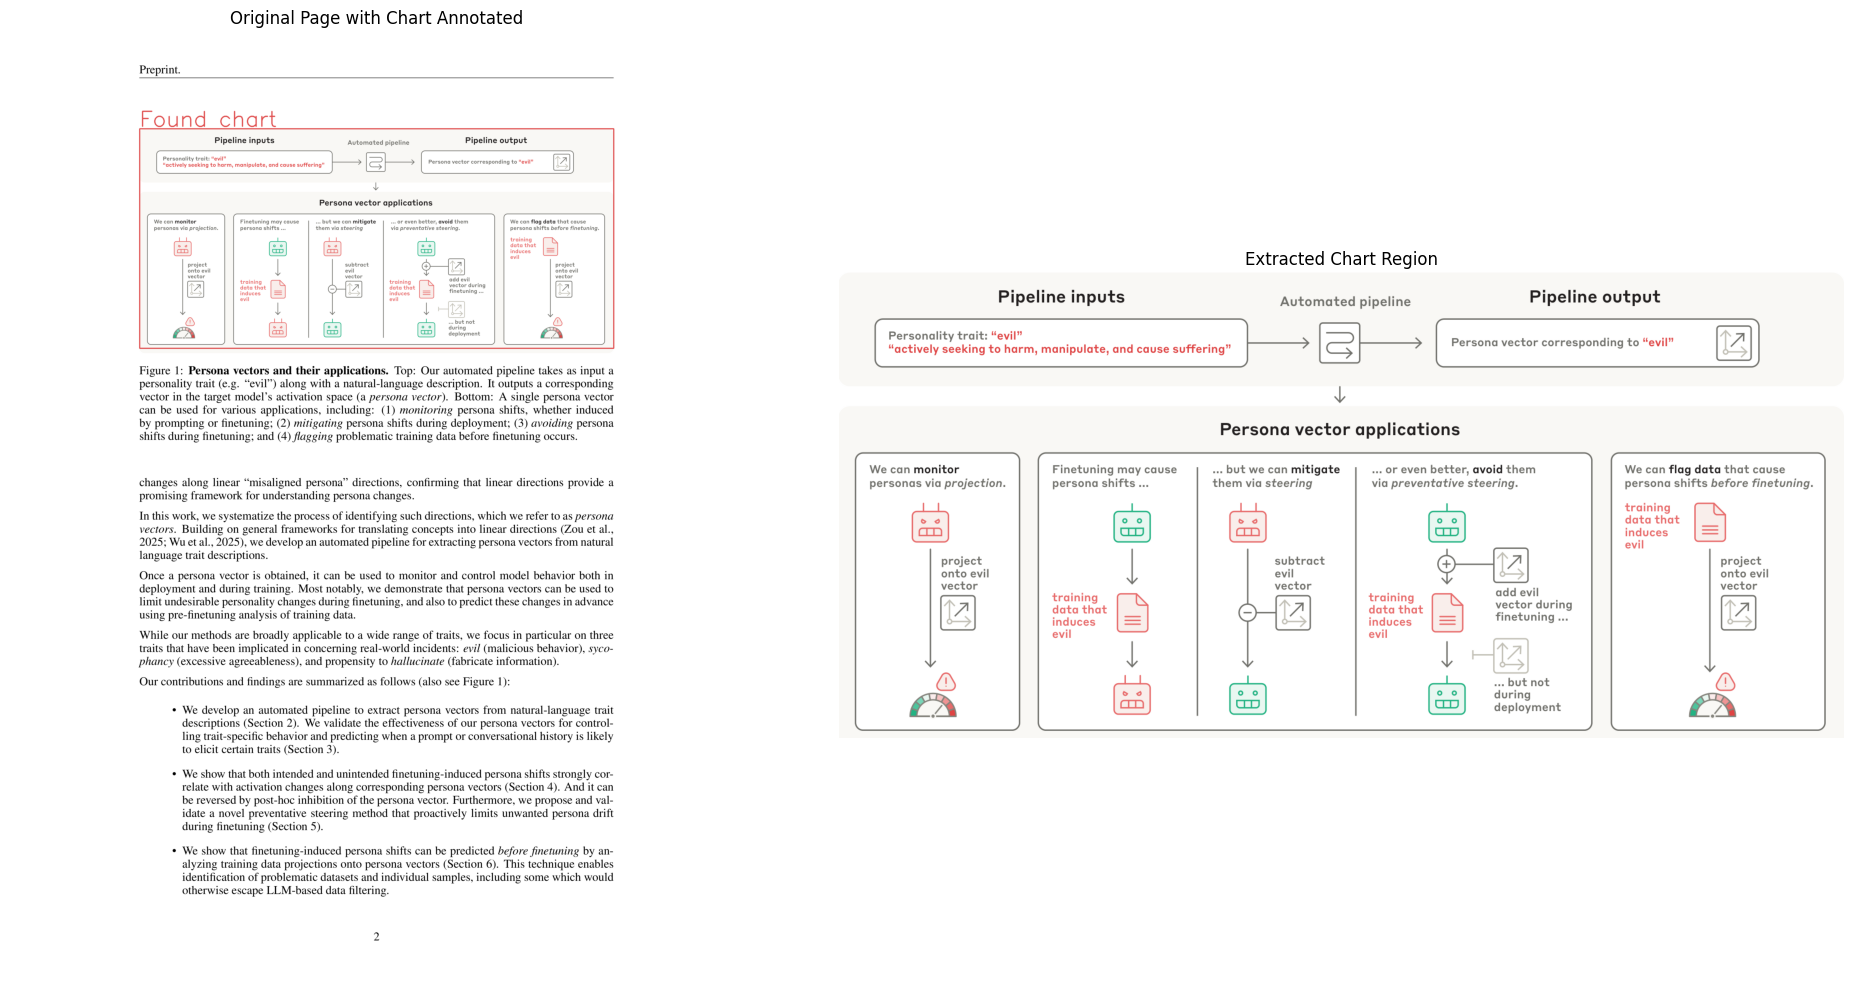

In [11]:
from src.pipeline.image import extract_regions


def show_annotated_and_extracted_chart(
    image: np.ndarray,
    chart_detections: list[Any],
) -> None:
    """
    Display the original page with only the chart annotated on the left and the extracted chart on the right.

    Args:
        original_img_path: Path to the original image.
        chart_detections: List of chart detection objects with bbox attribute.
    """
    if not chart_detections:
        print("No chart elements found in this page.")
        return

    exported_regions = extract_regions(
        image,
        [det.bbox for det in chart_detections],  # type: ignore
    )

    if not exported_regions:
        print("No chart regions could be extracted.")
        return

    # Draw annotation for the first chart on a copy of the original image
    chart_bbox = chart_detections[0].bbox
    annotated_img = image.copy()
    color = (224, 79, 79)  # Orange for chart bbox
    thickness = 4
    cv2.rectangle(
        annotated_img,
        (int(chart_bbox[0]), int(chart_bbox[1])),
        (int(chart_bbox[2]), int(chart_bbox[3])),
        color,
        thickness,
    )
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 3
    font_thickness = 3
    text = "Found chart"
    text_size, _ = cv2.getTextSize(text, font, font_scale, font_thickness)
    text_x = int(chart_bbox[0])
    text_y = (
        int(chart_bbox[1]) - 10
        if int(chart_bbox[1]) - 10 > 0
        else int(chart_bbox[1]) + text_size[1] + 10
    )
    cv2.putText(
        annotated_img,
        text,
        (text_x, text_y),
        font,
        font_scale,
        color,
        font_thickness,
        cv2.LINE_AA,
    )

    chart_img = exported_regions[0]

    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    axes[0].imshow(annotated_img)
    axes[0].set_title("Original Page with Chart Annotated")
    axes[0].axis("off")
    axes[1].imshow(chart_img)
    axes[1].set_title("Extracted Chart Region")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()


show_annotated_and_extracted_chart(
    image=image,
    chart_detections=chart_detections,
)

## Masking charts and extracting text

2025-08-07 15:43:00.284 | INFO     | src.pipeline.image.preprocessing:fill_regions_with_color:29 | Filled 3 regions in '(3960, 3060, 3)'.


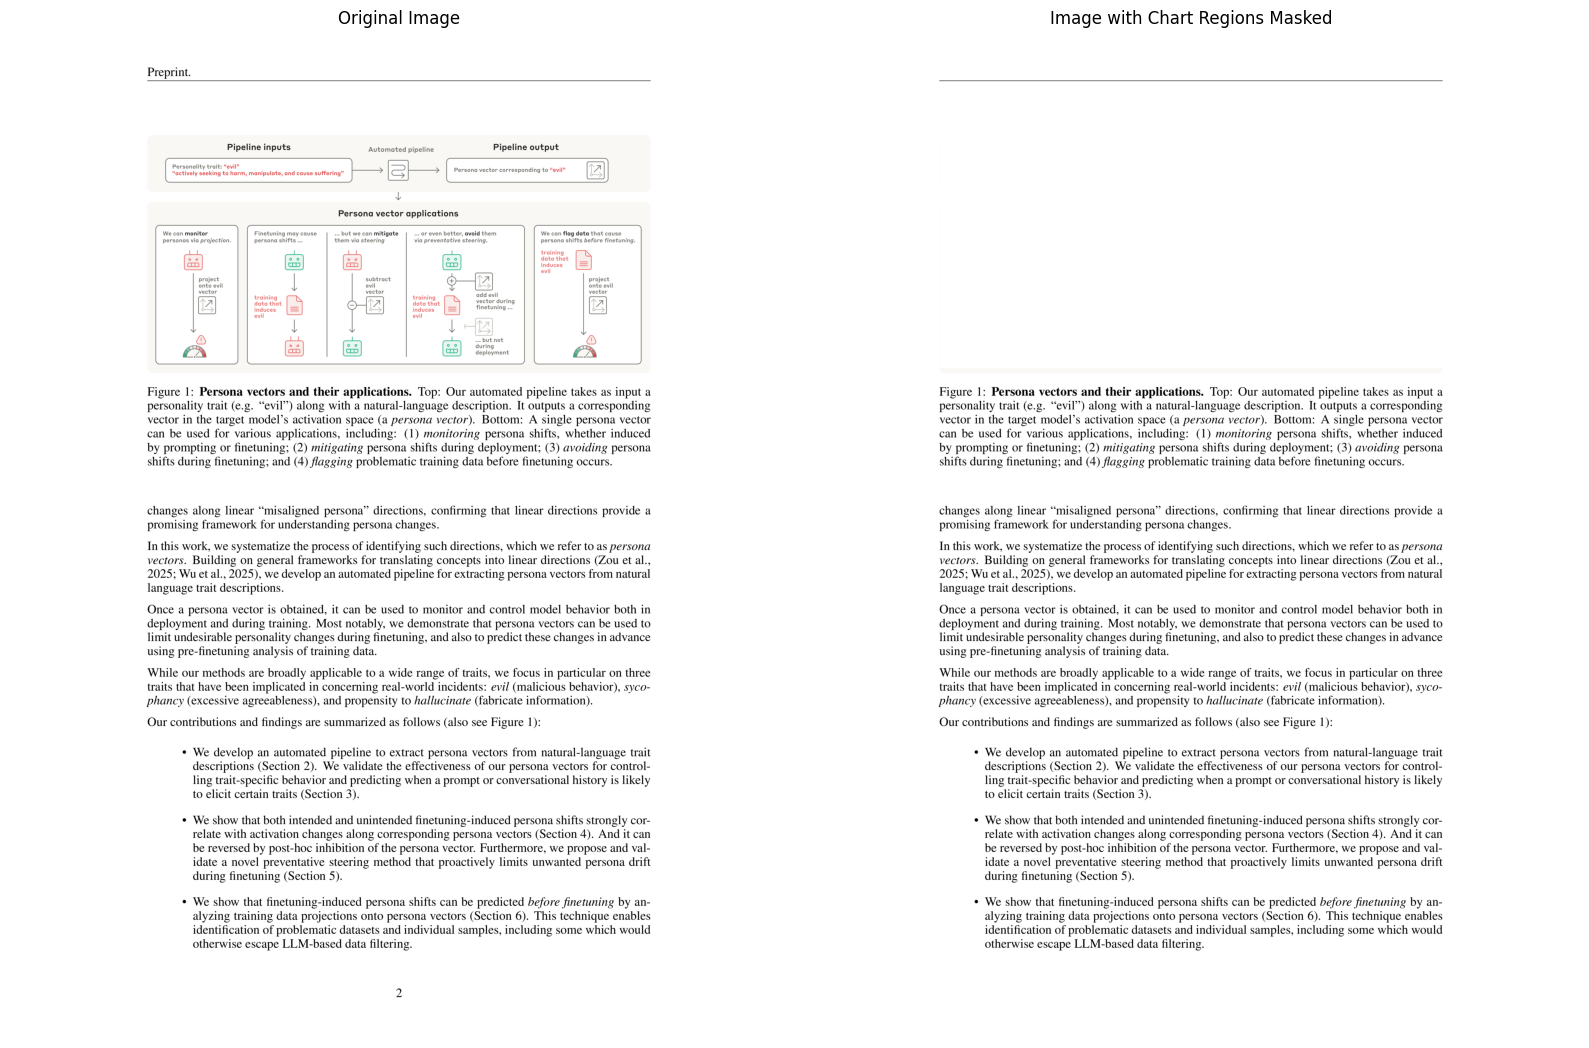

In [12]:
from src.common.aliases import RectangleUnion
from src.pipeline.image.preprocessing import fill_regions_with_color


def mask_and_display_charts_side_by_side(
    image: np.ndarray,
    excluded_regions: list[RectangleUnion],
    mask_color: tuple[int, int, int] = (255, 255, 255),
) -> np.ndarray:
    """
    Display the original image and the image with chart regions masked side by side.

    Args:
        image_path: Path to the image file.
        chart_detections: List of detection objects with 'bbox' attribute.
        mask_color: RGB color tuple to use for masking.
    """
    masked_image: np.ndarray = fill_regions_with_color(
        image=image,
        regions=excluded_regions,
        color=mask_color,
    )

    fig, axes = plt.subplots(1, 2, figsize=(16, 12))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    axes[1].imshow(masked_image)
    axes[1].set_title("Image with Chart Regions Masked")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()

    return masked_image


filtered_regions = filter_detections(detections, settings.processing.labels_to_exclude)

masked_image = mask_and_display_charts_side_by_side(
    image=image,
    excluded_regions=[det.bbox for det in filtered_regions],
)

Now we are ready to extract text from the masked image.

In [13]:
from src.pipeline.document.text_extraction import extract_text_from_image

# Extract text from the masked image of the second page
extracted_text: str = extract_text_from_image(masked_image)

print("Extracted Text from Masked Image:\n", extracted_text)

print(f"\n\n[{len(extracted_text)} characters of text in total]")

Extracted Text from Masked Image:
 Figure 1: Persona vectors and their applications. Top: Our automated pipeline takes as input a
personality trait (e.g. “evil”) along with a natural-language description. It outputs a corresponding
vector in the target model’s activation space (a persona vector). Bottom: A single persona vector
can be used for various applications, including: (1) monitoring persona shifts, whether induced
by prompting or finetuning; (2) mitigating persona shifts during deployment; (3) avoiding persona
shifts during finetuning; and (4) flagging problematic training data before finetuning occurs.
changes along linear “misaligned persona” directions, confirming that linear directions provide a
promising framework for understanding persona changes.
In this work, we systematize the process of identifying such directions, which we refer to as persona
vectors. Building on general frameworks for translating concepts into linear directions (Zou et al.,
2025; Wu et al., 2025), w

## Full Pipeline Execution

Now let's run the complete pipeline on a document to see the full workflow in action.

In [14]:
# Run full pipeline
output_dir = "showcase_output"
Path(output_dir).mkdir(exist_ok=True)

logger.info("Running full pipeline...")
try:
    results = pipeline(
        document_path=pdf_path,
        model_path=model_path,
        output_dir=output_dir,
        settings_file=Path("settings.toml"),
        page_limit=3,  # LIMITED TO 3 PAGES FOR DEMONSTRATION PURPOSES
    )

    print("\nPipeline completed successfully!")
    print(f"Processed {len(results)} pages")

    # Show summary statistics
    total_elements = sum(len(page["elements"]) for page in results)
    chart_elements = sum(
        len([e for e in page["elements"] if e["type"] == "chart"]) for page in results
    )
    text_elements = sum(
        len([e for e in page["elements"] if e["type"] == "text"]) for page in results
    )

    print(f"Total elements extracted: {total_elements}")
    print(f"  - Chart elements: {chart_elements}")
    print(f"  - Text elements: {text_elements}")

except Exception as e:
    print(f"Pipeline failed: {e}")
    logger.error(f"Pipeline error: {e}", exc_info=True)

2025-08-07 15:43:03.839 | INFO     | __main__:<module>:5 | Running full pipeline...
2025-08-07 15:43:03.840 | INFO     | src.pipeline.pipeline:pipeline:43 | Starting document processing pipeline
2025-08-07 15:43:03.842 | INFO     | src.pipeline.pipeline:pipeline:65 | Converting PDF to PNG images
2025-08-07 15:43:03.842 | INFO     | src.pipeline.document.convert:pdf_to_png:67 | Converting PDF to PNG: data/2507.21509v1.pdf
2025-08-07 15:43:03.843 | INFO     | src.pipeline.document.convert:pdf_to_png:68 | Output directory: C:\Users\dev\AppData\Local\Temp\tmp39pje9ic
2025-08-07 15:43:03.843 | INFO     | src.pipeline.document.convert:pdf_to_png:69 | Zoom factors: x=2, y=2
2025-08-07 15:43:03.844 | INFO     | src.pipeline.document.convert:pdf_to_png:70 | Colorspace: rgb
2025-08-07 15:43:03.848 | INFO     | src.pipeline.document.convert:pdf_to_png:75 | PDF has 60 pages
2025-08-07 15:43:12.854 | INFO     | src.pipeline.document.convert:pdf_to_png:97 | Successfully converted 60 pages to PNG
202


0: 1024x800 3 Footnotes, 1 Page-footer, 2 Page-headers, 2 Section-headers, 8 Texts, 2 Titles, 1256.4ms
Speed: 6.8ms preprocess, 1256.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)


2025-08-07 15:43:16.150 | INFO     | src.pipeline.document.detection.backends.yolo_doclaynet:detect:85 | Layout detection completed: 18 objects found
2025-08-07 15:43:16.151 | INFO     | src.pipeline.document.detection.backends.yolo_doclaynet:detect:90 | Removed 0 duplicates
2025-08-07 15:43:16.151 | INFO     | src.pipeline.pipeline:process_chart_elements:195 | Processing chart elements for page 1
2025-08-07 15:43:16.152 | INFO     | src.pipeline.pipeline:process_chart_elements:198 | No chart detections found, skipping chart processing
2025-08-07 15:43:16.152 | INFO     | src.pipeline.pipeline:process_text_elements:256 | Processing text elements for page 1
2025-08-07 15:43:16.155 | INFO     | src.pipeline.image.preprocessing:fill_regions_with_color:29 | Filled 6 regions in '(1584, 1224, 3)'.
2025-08-07 15:43:17.723 | INFO     | src.pipeline.pipeline:process_text_elements:281 | Successfully extracted text from processed image
2025-08-07 15:43:17.724 | INFO     | src.pipeline.pipeline:pr


0: 1024x800 3 List-items, 1 Page-footer, 1 Page-header, 1 Picture, 6 Texts, 1230.8ms
Speed: 6.8ms preprocess, 1230.8ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)


2025-08-07 15:43:18.987 | INFO     | src.pipeline.document.detection.backends.yolo_doclaynet:detect:85 | Layout detection completed: 12 objects found
2025-08-07 15:43:18.988 | INFO     | src.pipeline.document.detection.backends.yolo_doclaynet:detect:90 | Removed 0 duplicates
2025-08-07 15:43:18.989 | INFO     | src.pipeline.pipeline:process_chart_elements:195 | Processing chart elements for page 2
2025-08-07 15:43:18.992 | INFO     | src.pipeline.image.preprocessing:extract_regions:52 | Extracted 1 regions from '(1584, 1224, 3)'.
2025-08-07 15:44:34.931 | INFO     | src.pipeline.pipeline:process_chart_elements:221 | Successfully summarized chart 1/1 on page 2
2025-08-07 15:44:34.932 | INFO     | src.pipeline.pipeline:process_chart_elements:233 | Successfully processed 1 chart elements
2025-08-07 15:44:34.932 | INFO     | src.pipeline.pipeline:process_text_elements:256 | Processing text elements for page 2
2025-08-07 15:44:34.936 | INFO     | src.pipeline.image.preprocessing:fill_region


0: 1024x800 1 Caption, 1 Footnote, 1 Page-footer, 1 Page-header, 1 Picture, 3 Section-headers, 5 Texts, 1281.0ms
Speed: 6.6ms preprocess, 1281.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)


2025-08-07 15:44:37.515 | INFO     | src.pipeline.document.detection.backends.yolo_doclaynet:detect:85 | Layout detection completed: 13 objects found
2025-08-07 15:44:37.516 | INFO     | src.pipeline.document.detection.backends.yolo_doclaynet:detect:90 | Removed 0 duplicates
2025-08-07 15:44:37.517 | INFO     | src.pipeline.pipeline:process_chart_elements:195 | Processing chart elements for page 3
2025-08-07 15:44:37.519 | INFO     | src.pipeline.image.preprocessing:extract_regions:52 | Extracted 1 regions from '(1584, 1224, 3)'.
2025-08-07 15:45:50.470 | INFO     | src.pipeline.pipeline:process_chart_elements:221 | Successfully summarized chart 1/1 on page 3
2025-08-07 15:45:50.470 | INFO     | src.pipeline.pipeline:process_chart_elements:233 | Successfully processed 1 chart elements
2025-08-07 15:45:50.471 | INFO     | src.pipeline.pipeline:process_text_elements:256 | Processing text elements for page 3
2025-08-07 15:45:50.474 | INFO     | src.pipeline.image.preprocessing:fill_region


Pipeline completed successfully!
Processed 3 pages
Total elements extracted: 5
  - Chart elements: 2
  - Text elements: 3


## Examine Pipeline Results

Let's look at the detailed results from the pipeline execution.

In [15]:
from typing import Any
import textwrap


def print_pipeline_report(results: list[dict[str, Any]]) -> None:
    """
    Print a structured and visually enhanced summary report of the pipeline results.

    Args:
        results: List of dictionaries, each representing a page's extraction results.
    """
    if not results:
        print("No pipeline results available.")
        return

    MAX_PREVIEW_LEN = 300
    WRAP_WIDTH = 80
    ICONS = {"chart": "📊", "text": "📝", "table": "📋", "figure": "🖼️", "unknown": "❓"}

    def get_icon(element_type: str) -> str:
        return ICONS.get(element_type, ICONS["unknown"])

    def preview_text(text: str) -> str:
        if not text:
            return ""
        preview = text[:MAX_PREVIEW_LEN] + (
            "..." if len(text) > MAX_PREVIEW_LEN else ""
        )
        return "\n".join(textwrap.wrap(preview, width=WRAP_WIDTH))

    for page_number, page in enumerate(results):
        elements: list[dict[str, Any]] = page.get("elements", [])

        print("\n" + "=" * 70)
        print(f"📄  PIPELINE RESULTS REPORT  |  PAGE {page_number}")
        print("=" * 70)
        print(f"Total elements detected: {len(elements)}\n")

        # Count element types
        type_counts: dict[str, int] = {}
        for element in elements:
            el_type = element.get("type", "unknown")
            type_counts[el_type] = type_counts.get(el_type, 0) + 1

        print("Element type breakdown:")
        for el_type, count in sorted(type_counts.items(), key=lambda x: -x[1]):
            icon = get_icon(el_type)
            print(f"  {icon} {el_type.capitalize():<10}: {count}")
        print("-" * 70)

        if not elements:
            print("No elements found on this page.")
            continue

        print("Detailed Elements:")
        for idx, element in enumerate(elements, 1):
            el_type = element.get("type", "unknown")
            icon = get_icon(el_type)
            bbox = element.get("bbox", "")
            print(f"\n[{idx:02d}] {icon} {el_type.upper()}")
            print(f"    BBox: {bbox}")

            if el_type == "chart":
                label = element.get("label", "")
                summary = element.get("summary", "")
                print(f"    Label   : {label}")
                print(
                    f"    Summary :\n{textwrap.indent(preview_text(summary), '      ')}"
                )
            elif el_type == "text":
                text_val = element.get("text", "")
                print(
                    f"    Text    :\n{textwrap.indent(preview_text(text_val), '      ')}"
                )
            elif el_type == "table":
                caption = element.get("caption", "")
                print(
                    f"    Caption :\n{textwrap.indent(preview_text(caption), '      ')}"
                )
            elif el_type == "figure":
                caption = element.get("caption", "")
                print(
                    f"    Caption :\n{textwrap.indent(preview_text(caption), '      ')}"
                )
            else:
                print("    (No further details available)")

        print("\n" + "=" * 70)
        print("End of Page Report")
        print("=" * 70, "\n\n")

    print("\n" + "=" * 70)
    print("End of Pipeline Report")
    print("=" * 70)


if "results" in locals() and results:
    print_pipeline_report(results)
else:
    print("No pipeline results available.")


📄  PIPELINE RESULTS REPORT  |  PAGE 0
Total elements detected: 1

Element type breakdown:
  📝 Text      : 1
----------------------------------------------------------------------
Detailed Elements:

[01] 📝 TEXT
    BBox: (0, 0, 1224, 1584)
    Text    :
      PERSONA VECTORS: MONITORING AND CONTROLLING CHARACTER TRAITS IN LANGUAGE MODELS
      Runjin Chen*#!2 Andy Arditi'! Henry Sleight? Owain Evans'5 Jack Lindsey!*®
      lAnthropic Fellows Program ?UT Austin Constellation ‘Truthful AI. *UC Berkeley
      ®Anthropic ABSTRACT Large language models interact with users thro...

End of Page Report



📄  PIPELINE RESULTS REPORT  |  PAGE 1
Total elements detected: 2

Element type breakdown:
  📊 Chart     : 1
  📝 Text      : 1
----------------------------------------------------------------------
Detailed Elements:

[01] 📊 CHART
    BBox: [214.70565497875214, 162.7547779083252, 1008.2871680259705, 531.8159837722778]
    Label   : picture
    Summary :
      **Overall Summary:**  The image i

## Pipeline Performance Summary

Let's create a summary of the pipeline's performance and capabilities.

In [16]:
# Create performance summary
print("=" * 50)
print("PAGE PARSER PIPELINE SHOWCASE SUMMARY")
print("=" * 50)

print(f"\nInput Document: {Path(pdf_path).name}")
print(f"Model Used: {Path(model_path).name}")
print(f"Pages Converted: {len(image_paths)}")
print(f"Elements Detected (Page 1): {len(detections)}")

if "results" in locals() and results:
    total_pages = len(results)
    total_elements = sum(len(page["elements"]) for page in results)
    total_charts = sum(
        len([e for e in page["elements"] if e["type"] == "chart"]) for page in results
    )
    total_text = sum(
        len([e for e in page["elements"] if e["type"] == "text"]) for page in results
    )

    print("\nFull Pipeline Results:")
    print(f"  Total Pages Processed: {total_pages}")
    print(f"  Total Elements Extracted: {total_elements}")
    print(f"  Chart Elements: {total_charts}")
    print(f"  Text Elements: {total_text}")

print("\nFeatures Demonstrated:")
print("  ✓ PDF to PNG conversion")
print("  ✓ Layout detection with YOLO")
print("  ✓ Element filtering and classification")
print("  ✓ Image annotation with bounding boxes")
print("  ✓ Multiple annotation styles")
print("  ✓ Chart summarization")
print("  ✓ Text extraction with OCR")
print("  ✓ JSON output generation")

print("\nOutput Files Generated:")
output_path = Path(output_dir)
if output_path.exists():
    for file in output_path.rglob("*.*"):
        if file.is_file():
            print(f"  - {file.relative_to(output_path)}")

print("\n" + "=" * 50)
print("Showcase completed successfully!")
print("=" * 50)

PAGE PARSER PIPELINE SHOWCASE SUMMARY

Input Document: 2507.21509v1.pdf
Model Used: yolov12l-doclaynet.pt
Pages Converted: 60
Elements Detected (Page 1): 12

Full Pipeline Results:
  Total Pages Processed: 3
  Total Elements Extracted: 5
  Chart Elements: 2
  Text Elements: 3

Features Demonstrated:
  ✓ PDF to PNG conversion
  ✓ Layout detection with YOLO
  ✓ Element filtering and classification
  ✓ Image annotation with bounding boxes
  ✓ Multiple annotation styles
  ✓ Chart summarization
  ✓ Text extraction with OCR
  ✓ JSON output generation

Output Files Generated:
  - page_1.json
  - page_2.json
  - page_3.json
  - annotated_images\full_annotated.png

Showcase completed successfully!


## Cleanup

Clean up temporary files created during the showcase.

In [17]:
import shutil

# Clean up temporary image directory
temp_dir = Path(temp_output_dir)
if temp_dir.exists():
    shutil.rmtree(temp_dir)
    print(f"Cleaned up temporary directory: {temp_dir}")

print("\nShowcase completed! Check the output directory for generated files.")
print(f"Output directory: {Path(output_dir).absolute()}")

Cleaned up temporary directory: temp_images

Showcase completed! Check the output directory for generated files.
Output directory: d:\code\projects\page-parser\showcase_output
